-  This notebook is to run active learning on current dataset and suggest next experimental plan

In [ ]:
# Add the src directory to sys.path
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from itertools import product
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import pandas as pd
import pickle

from Active_learning import *
from utils import *

In [ ]:
df_input = pd.read_csv('df_combine_20240510.csv')
df_input['num_vesicles'] = df_input['num_vesicles'].round().astype(int)
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input.to_csv('../../data/20240503/df_input_20240510.csv', index=False)

In [ ]:
# Update datapool
df_input_init = pd.read_csv('../../data/20240419/df_input_20240429.csv')
df_input_update = pd.concat([df_input_init, df_input])
df_input_update = df_input_update.reset_index(drop=True)
df_input_update.to_csv('../../data/20240503/df_input_update_20240511.csv', index = False)

In [2]:
df_input_update = pd.read_csv('../../data/20240503/df_input_update_20240511.csv')

In [3]:
df_input_update 

,Total_decanoic acid_Mass,Total_decanoate_Mass,Total_decylamine_Mass,Total_decyl trimethylamine_Mass,Total_decylsulfate_Mass,Total_decanol_Mass,Total_monocaprin_Mass,num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
91,0.190620,1.208960,1.231101,1.475907,1.170933,0.520281,0.466874,1
92,0.491643,0.182322,0.388658,0.231112,1.604425,0.882734,0.431782,1
93,1.301553,0.101654,1.315067,0.000000,1.515127,0.876510,0.285179,0
94,0.340037,0.729961,1.558145,0.717840,1.458615,0.788457,0.181488,4


In [4]:
df_input_update['num_vesicles'] = df_input_update['num_vesicles'].apply(lambda x: 0 if x < 1 else 1)
df_input_update

,Total_decanoic acid_Mass,Total_decanoate_Mass,Total_decylamine_Mass,Total_decyl trimethylamine_Mass,Total_decylsulfate_Mass,Total_decanol_Mass,Total_monocaprin_Mass,num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,1
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,1
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,1
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,1
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,1
...,...,...,...,...,...,...,...,...
91,0.190620,1.208960,1.231101,1.475907,1.170933,0.520281,0.466874,1
92,0.491643,0.182322,0.388658,0.231112,1.604425,0.882734,0.431782,1
93,1.301553,0.101654,1.315067,0.000000,1.515127,0.876510,0.285179,0
94,0.340037,0.729961,1.558145,0.717840,1.458615,0.788457,0.181488,1


In [5]:
# data already done the log1p transform
X = df_input_update.iloc[:,0:7].values
y = df_input_update.iloc[:,-1:].values.ravel()

In [50]:
# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}")

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    print(f"Iteration {i+1}: Test Accuracy = {test_accuracy:.4f}")

Iteration 1: Training Accuracy = 0.8816
Iteration 1: Test Accuracy = 0.6500
Iteration 2: Training Accuracy = 0.8026
Iteration 2: Test Accuracy = 0.8500
Iteration 3: Training Accuracy = 0.8553
Iteration 3: Test Accuracy = 0.9000
Iteration 4: Training Accuracy = 0.8816
Iteration 4: Test Accuracy = 0.7000
Iteration 5: Training Accuracy = 0.8289
Iteration 5: Test Accuracy = 0.6500
Iteration 6: Training Accuracy = 0.8684
Iteration 6: Test Accuracy = 0.7500
Iteration 7: Training Accuracy = 0.8158
Iteration 7: Test Accuracy = 0.7500
Iteration 8: Training Accuracy = 0.8684
Iteration 8: Test Accuracy = 0.8000
Iteration 9: Training Accuracy = 0.8816
Iteration 9: Test Accuracy = 0.7500
Iteration 10: Training Accuracy = 0.8421
Iteration 10: Test Accuracy = 0.8500


In [6]:
# Showing std for repeated runs
train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)
    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}")

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)
    print(f"Iteration {i+1}: Test Accuracy = {test_accuracy:.4f}")

# Calculate the average and standard deviation of training and testing accuracies
average_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"\nAverage Training Accuracy: {average_train_accuracy:.4f}")
print(f"Training Accuracy Standard Deviation: {std_train_accuracy:.4f}")
print(f"Average Test Accuracy: {average_test_accuracy:.4f}")
print(f"Test Accuracy Standard Deviation: {std_test_accuracy:.4f}")

Iteration 1: Training Accuracy = 0.8816
Iteration 1: Test Accuracy = 0.6500
Iteration 2: Training Accuracy = 0.8026
Iteration 2: Test Accuracy = 0.8500
Iteration 3: Training Accuracy = 0.8553
Iteration 3: Test Accuracy = 0.9000
Iteration 4: Training Accuracy = 0.8816
Iteration 4: Test Accuracy = 0.7000
Iteration 5: Training Accuracy = 0.8289
Iteration 5: Test Accuracy = 0.6500
Iteration 6: Training Accuracy = 0.8684
Iteration 6: Test Accuracy = 0.7500
Iteration 7: Training Accuracy = 0.8158
Iteration 7: Test Accuracy = 0.7500
Iteration 8: Training Accuracy = 0.8684
Iteration 8: Test Accuracy = 0.8000
Iteration 9: Training Accuracy = 0.8816
Iteration 9: Test Accuracy = 0.7500
Iteration 10: Training Accuracy = 0.8421
Iteration 10: Test Accuracy = 0.8500

Average Training Accuracy: 0.8526
Training Accuracy Standard Deviation: 0.0275
Average Test Accuracy: 0.7650
Test Accuracy Standard Deviation: 0.0808


In [9]:
# working on whole dagtaset
kernel = 1.0 * RBF(1)
model = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)
# model = GaussianProcessClassifier()
# model.fit(X_resampled, y_resampled)
model.score(X, y)

0.8541666666666666

In [10]:
bounds = torch.tensor([[0., 0., 0., 0., 0., 0., 0.],[5., 5., 5., 5., 5., 1.5, 1.0]])
bounds = torch.log1p(bounds)
bounds

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.7918, 1.7918, 1.7918, 1.7918, 1.7918, 0.9163, 0.6931]])

In [9]:
# Sample points in the 7-dimensional space
num_samples = 10000000
num_dimensions = bounds.shape[1]
samples = torch.rand(num_samples, num_dimensions)  # Generate random samples in [0, 1)

# Scale the samples to the specified bounds
scaled_samples = samples * (bounds[1] - bounds[0]) + bounds[0]

# Now scaled_samples contains the sampled points in the specified bounds
scaled_samples

tensor([[0.9372, 0.6170, 0.4033,  ..., 1.4589, 0.1996, 0.0855],
        [1.1097, 1.4038, 1.3839,  ..., 0.1729, 0.0747, 0.3372],
        [0.5692, 0.1267, 1.0926,  ..., 1.2868, 0.6212, 0.0358],
        ...,
        [0.0963, 0.4747, 0.9226,  ..., 0.4556, 0.6233, 0.0150],
        [1.1665, 1.5774, 0.6867,  ..., 1.1935, 0.0501, 0.5352],
        [0.4157, 1.6155, 0.5044,  ..., 0.1980, 0.7623, 0.2249]])

In [14]:
df_sample = pd.DataFrame(scaled_samples, columns=[df_input_update.iloc[:,0:-1].columns])
df_sample

,Total_decanoic acid_Mass,Total_decanoate_Mass,Total_decylamine_Mass,Total_decyl trimethylamine_Mass,Total_decylsulfate_Mass,Total_decanol_Mass,Total_monocaprin_Mass
0,0.937157,0.616995,0.403315,0.328508,1.458859,0.199628,0.085493
1,1.109658,1.403843,1.383918,0.374125,0.172889,0.074726,0.337240
2,0.569216,0.126664,1.092620,0.883421,1.286847,0.621221,0.035816
3,0.126259,0.802185,0.278142,0.394667,0.505545,0.377274,0.068398
4,0.027255,0.846922,0.487982,0.528082,0.501384,0.414047,0.467014
...,...,...,...,...,...,...,...
9999995,0.035254,1.296694,0.373350,0.870632,1.287258,0.898971,0.143738
9999996,1.241879,1.181184,0.838997,1.049255,0.415594,0.668733,0.430069
9999997,0.096281,0.474653,0.922579,0.635197,0.455598,0.623338,0.015023
9999998,1.166480,1.577386,0.686687,1.548084,1.193493,0.050074,0.535180


In [28]:
df_sample.to_csv('df_sample_20240512.csv', index = False)

In [2]:
df_sample = pd.read_csv('df_sample_20240512.csv')

In [3]:
def cal_entropy(data):
    entropies = []
    for row in data:
        # Replace 0 values with a small non-zero value (e.g., machine epsilon)
        row_nonzero = np.where(row == 0, np.finfo(float).eps, row)
        
        # Calculate entropy for the current row
        entropy_value = entropy(row_nonzero, base=2)
        
        # Append the entropy value to the list
        entropies.append(entropy_value)

    return np.array(entropies)

In [ ]:
# Save the model to a file
with open('../../data/20240503/model/GPC_model_20240512.pkl', 'wb') as file:
    pickle.dump(model, file)

In [9]:
# Load the model from the file
with open('../../data/20240503/model/GPC_model_20240513.pkl', 'rb') as file:
    model = pickle.load(file)

In [10]:
model.kernel_.get_params()

{'k1': 2.71**2,
 'k2': RBF(length_scale=2.17),
 'k1__constant_value': 7.365242713917035,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 2.1663044274527556,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

In [5]:
start_time = time.time()

# Your code snippet
pred_prob = model.predict_proba(df_sample.values)

# Record end time
end_time = time.time()

# Calculate running time
running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 99.22726082801819 seconds


In [7]:
entropy_value = cal_entropy(pred_prob)
entropy_value

array([0.88404528, 0.93671107, 0.85885243, ..., 0.89520844, 0.29132384,
       0.97184018])

In [8]:
entropy_value.sum()

7516738.705192391

In [19]:
entropy_value = cal_entropy(pred_prob)
entropy_value

array([0.88404528, 0.93671107, 0.85885243, ..., 0.89520844, 0.29132384,
       0.97184018])

In [20]:
# Get indices of the first 48 samples with highest entropy
top_indices = np.argsort(entropy_value)[::-1][:48]
top_indices

array([2931883, 1685355, 9662016, 3279110, 2561323, 6952172, 1359504,
       6865179, 6631935, 3013146, 5607477, 2619129, 4279548,   48376,
       2648482, 8768588, 2287336, 1998153, 4517029, 7711019, 6712202,
       1316231, 6236512, 7393802, 3262769,  516727, 6594822, 2653820,
       1732845, 9952779, 7822822,  140013, 6791262, 6829097, 5776122,
       7699329, 3553382, 7180687, 5270761, 9237495, 5747729, 6298732,
       3337412,  103991, 5997234, 2812842, 6655449, 2590206])

In [22]:
candidates = df_sample.iloc[top_indices]
candidates

,Total_decanoic acid_Mass,Total_decanoate_Mass,Total_decylamine_Mass,Total_decyl trimethylamine_Mass,Total_decylsulfate_Mass,Total_decanol_Mass,Total_monocaprin_Mass
2931883,0.074744,0.594881,0.875802,1.051787,0.495784,0.266799,0.542363
1685355,0.268085,0.835497,1.238887,0.315519,0.805561,0.484462,0.353930
9662016,1.058207,0.203586,0.691650,1.749687,0.026492,0.750333,0.490991
3279110,0.157549,1.529241,0.158801,0.503611,0.904493,0.683732,0.084733
2561323,0.998320,0.135457,0.490282,1.484047,0.178822,0.255426,0.372741
6952172,0.103878,1.342298,0.787926,1.208077,0.123916,0.563109,0.428621
1359504,0.125428,0.604032,1.504570,0.863475,0.507537,0.625490,0.508933
6865179,0.106951,0.492699,1.167155,0.428012,0.922369,0.889829,0.565289
6631935,0.070977,1.190317,1.082221,0.980083,0.238536,0.058448,0.384010
3013146,1.135843,0.579175,0.121016,0.989420,0.219299,0.357199,0.399398


In [25]:
# Transform it back to original scale

In [27]:
original_scale_df = np.expm1(candidates)
original_scale_df

,Total_decanoic acid_Mass,Total_decanoate_Mass,Total_decylamine_Mass,Total_decyl trimethylamine_Mass,Total_decylsulfate_Mass,Total_decanol_Mass,Total_monocaprin_Mass
2931883,0.077608,0.812815,1.400800,1.862762,0.641785,0.305779,0.720066
1685355,0.307458,1.305960,2.451771,0.370971,1.237952,0.623301,0.424655
9662016,1.881200,0.225790,0.997009,4.752803,0.026846,1.117705,0.633934
3279110,0.170638,3.614673,0.172104,0.654686,1.470679,0.981259,0.088427
2561323,1.713718,0.145060,0.632776,3.410760,0.195807,0.291011,0.451709
6952172,0.109465,2.827829,1.198831,2.347041,0.131921,0.756124,0.535139
1359504,0.133633,0.829481,3.502217,1.371386,0.661195,0.869162,0.663516
6865179,0.112880,0.636728,2.212838,0.534205,1.515242,1.434713,0.759957
6631935,0.073557,2.288124,1.951227,1.664679,0.269389,0.060190,0.468161
3013146,2.113798,0.784566,0.128643,1.689673,0.245204,0.429320,0.490927


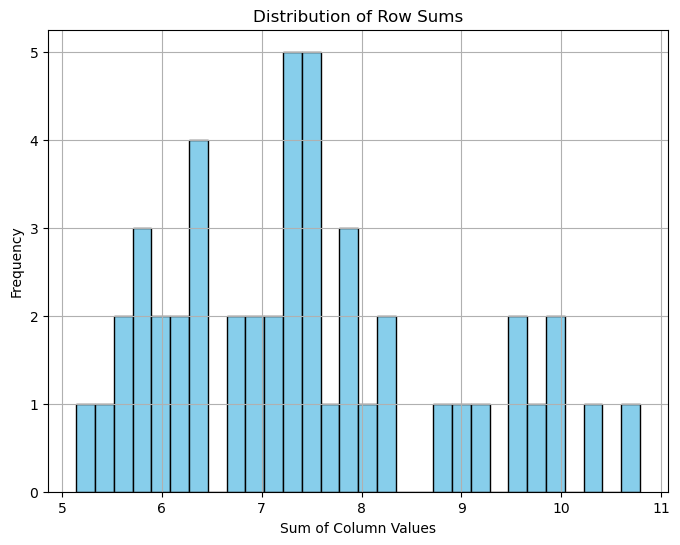

In [28]:
row_sums = original_scale_df.sum(axis=1)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(row_sums, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Row Sums')
plt.xlabel('Sum of Column Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [23]:
candidates.to_csv('candidates_20240513.csv', index = False)

### Create dispense volume

In [29]:
original_scale_df.to_csv('original_scale_df_GPC_20240513.csv', index=False)

In [33]:
solutes = ['decanoic acid', 'decanoate', 'decylamine', 'decyl trimethylamine', 'decylsulfate', 'decanol', 'monocaprin']

In [36]:
dispense_df = get_dispense_volume(original_scale_df, solutes, allow_zero=True)
len(dispense_df)

48

In [37]:
dispense_df 

,Total_decanoic acid_Mass (50 mM),Total_decanoic acid_Mass (10 mM),Total_decanoic acid_Mass (2 mM),Total_decanoate_Mass (50 mM),Total_decanoate_Mass (10 mM),Total_decanoate_Mass (2 mM),Total_decylamine_Mass (50 mM),Total_decylamine_Mass (10 mM),Total_decylamine_Mass (2 mM),Total_decyl trimethylamine_Mass (50 mM),Total_decyl trimethylamine_Mass (10 mM),Total_decyl trimethylamine_Mass (2 mM),Total_decylsulfate_Mass (50 mM),Total_decylsulfate_Mass (10 mM),Total_decylsulfate_Mass (2 mM),Total_decanol_Mass (15 mM),Total_decanol_Mass (3 mM),Total_monocaprin_Mass (10 mM),Total_monocaprin_Mass (2 mM)
2931883,0.0,0.0,7.8,0.0,16.3,0.0,5.6,0.0,0.0,7.5,0.0,0.0,0.0,12.8,0.0,4.1,0.0,14.4,0.0
1685355,0.0,6.1,0.0,5.2,0.0,0.0,9.8,0.0,0.0,0.0,7.4,0.0,5.0,0.0,0.0,8.3,0.0,8.5,0.0
9662016,7.5,0.0,0.0,0.0,4.5,0.0,0.0,19.9,0.0,19.0,0.0,0.0,0.0,0.0,2.7,14.9,0.0,12.7,0.0
3279110,0.0,0.0,17.1,14.5,0.0,0.0,0.0,0.0,17.2,0.0,13.1,0.0,5.9,0.0,0.0,13.1,0.0,0.0,8.8
2561323,6.9,0.0,0.0,0.0,0.0,14.5,0.0,12.7,0.0,13.6,0.0,0.0,0.0,0.0,19.6,0.0,19.4,9.0,0.0
6952172,0.0,0.0,10.9,11.3,0.0,0.0,4.8,0.0,0.0,9.4,0.0,0.0,0.0,0.0,13.2,10.1,0.0,10.7,0.0
1359504,0.0,0.0,13.4,0.0,16.6,0.0,14.0,0.0,0.0,5.5,0.0,0.0,0.0,13.2,0.0,11.6,0.0,13.3,0.0
6865179,0.0,0.0,11.3,0.0,12.7,0.0,8.9,0.0,0.0,0.0,10.7,0.0,6.1,0.0,0.0,19.1,0.0,15.2,0.0
6631935,0.0,0.0,7.4,9.2,0.0,0.0,7.8,0.0,0.0,6.7,0.0,0.0,0.0,5.4,0.0,0.0,4.0,9.4,0.0
3013146,8.5,0.0,0.0,0.0,15.7,0.0,0.0,0.0,12.9,6.8,0.0,0.0,0.0,4.9,0.0,5.7,0.0,9.8,0.0


In [38]:
dispense_df.to_csv('dispense_df_GPC_20240513.csv', index=False)

In [39]:
# Repeat the dataframe to have 96 rows
df_repeated = pd.concat([dispense_df] * 2, ignore_index=True)

# Create Labware_Deck_Slot column
df_repeated['Labware_Deck_Slot'] = [1] * 48 + [2] * 48

# Create Destination_Well column based on the well pattern
destination_well = []

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    for i in range(1, 13):
        destination_well.append(f"{letter}{i}")

df_repeated['Destination_Well'] = destination_well

# Rearrange columns
df_repeated = df_repeated[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df.columns)]

# Save to Excel with two sheets
with pd.ExcelWriter('../../data/20240503/dispense_df_20240513.xlsx') as writer:
    # Write df_repeated to sheet Plate1
    df_repeated.to_excel(writer, sheet_name='Plate1', index=False)
    
    # Write df_repeated to sheet Plate2
    df_repeated.to_excel(writer, sheet_name='Plate2', index=False)

In [ ]:
# change scale back and correct column names

In [42]:
df_input_update

,Total_decanoic acid_Mass,Total_decanoate_Mass,Total_decylamine_Mass,Total_decyl trimethylamine_Mass,Total_decylsulfate_Mass,Total_decanol_Mass,Total_monocaprin_Mass,num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
91,0.190620,1.208960,1.231101,1.475907,1.170933,0.520281,0.466874,1
92,0.491643,0.182322,0.388658,0.231112,1.604425,0.882734,0.431782,1
93,1.301553,0.101654,1.315067,0.000000,1.515127,0.876510,0.285179,0
94,0.340037,0.729961,1.558145,0.717840,1.458615,0.788457,0.181488,4


In [43]:
# Rename columns
df_input_update.columns = [col.replace('_Mass', '_mM') for col in df_input_update.columns]

# Apply inverse of log1p transformation to the first 7 columns
for col in df_input_update.columns[:7]:
    df_input_update[col] = np.expm1(df_input_update[col])

df_input_update

,Total_decanoic acid_mM,Total_decanoate_mM,Total_decylamine_mM,Total_decyl trimethylamine_mM,Total_decylsulfate_mM,Total_decanol_mM,Total_monocaprin_mM,num_vesicles
0,0.850,1.600,2.425,3.725,4.350,0.5550,0.785,22
1,3.425,0.905,0.192,1.875,2.375,0.2310,0.113,9
2,2.200,1.025,2.650,4.975,4.250,0.1725,0.225,6
3,3.625,4.975,0.465,0.074,3.375,0.8025,0.120,2
4,2.225,3.225,4.350,1.425,1.750,1.1175,0.350,36
...,...,...,...,...,...,...,...,...
91,0.210,2.350,2.425,3.375,2.225,0.6825,0.595,1
92,0.635,0.200,0.475,0.260,3.975,1.4175,0.540,1
93,2.675,0.107,2.725,0.000,3.550,1.4025,0.330,0
94,0.405,1.075,3.750,1.050,3.300,1.2000,0.199,4


In [44]:
df_input_update.columns = df_input_update.columns.str.replace('_Total', '')
df_input_update

,Total_decanoic acid_mM,Total_decanoate_mM,Total_decylamine_mM,Total_decyl trimethylamine_mM,Total_decylsulfate_mM,Total_decanol_mM,Total_monocaprin_mM,num_vesicles
0,0.850,1.600,2.425,3.725,4.350,0.5550,0.785,22
1,3.425,0.905,0.192,1.875,2.375,0.2310,0.113,9
2,2.200,1.025,2.650,4.975,4.250,0.1725,0.225,6
3,3.625,4.975,0.465,0.074,3.375,0.8025,0.120,2
4,2.225,3.225,4.350,1.425,1.750,1.1175,0.350,36
...,...,...,...,...,...,...,...,...
91,0.210,2.350,2.425,3.375,2.225,0.6825,0.595,1
92,0.635,0.200,0.475,0.260,3.975,1.4175,0.540,1
93,2.675,0.107,2.725,0.000,3.550,1.4025,0.330,0
94,0.405,1.075,3.750,1.050,3.300,1.2000,0.199,4


In [45]:
df_input_update.to_csv('df_input_update_ori_20240513.csv', index=False)